# 📊 Implied Volatility Surface Builder

This project implements a full pipeline to construct and visualize the **Implied Volatility Surface** for European options using real-time market data. It leverages the Black-Scholes pricing model and root-finding techniques to compute the implied volatility from observed market prices.

The main goals of the project are:

- ✅ Fetch option chain data for a given stock ticker using `yfinance`
- ✅ Compute the **implied volatility** (IV) for call and put options across multiple strikes and expiration dates
- ✅ Construct a 3D **IV surface plot** that visually captures the volatility smile and skew phenomena
- ✅ Provide a foundation for further research or dashboard deployment using Streamlit

This notebook is designed to be educational, interactive, and extendable — suitable for both quants and developers in financial modeling.


## 🧰 Import Required Libraries

We begin by importing core libraries used for data fetching, numerical computation, and visualization.

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import brentq
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

## 📥 Fetch Option Chain Data Using yfinance

This function uses `yfinance` to download the complete option chain (calls and puts) for a given stock ticker across all available expiration dates.

Each record contains details such as strike price, bid/ask, and expiration, and is tagged with the option type (`call` or `put`).

In [2]:
def get_option_chain(ticker):
    stock = yf.Ticker(ticker)
    expiration_dates = stock.options
    full_chain = []

    for date in expiration_dates:
        opt_chain = stock.option_chain(date)
        calls = opt_chain.calls.copy()
        calls['expirationDate'] = date
        calls['optionType'] = 'call'

        puts = opt_chain.puts.copy()
        puts['expirationDate'] = date
        puts['optionType'] = 'put'

        full_chain.extend([calls, puts])

    df = pd.concat(full_chain, axis=0)
    df.reset_index(drop=True, inplace=True)
    return df


## 🧠 Black-Scholes Analytical Pricing Model

The Black-Scholes model is used to compute theoretical prices of European call and put options. It assumes constant volatility and interest rate, and log-normal distribution of asset returns.

Below is the function to calculate option prices given volatility (`σ`) and other parameters:


In [3]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:
        return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

## 🔍 Calculate Implied Volatility

We invert the Black-Scholes formula using numerical methods (Brent’s method) to compute the **implied volatility** from observed market prices.

Implied volatility reflects the market's expectation of future volatility — it's one of the most important measures in options trading.

In [4]:
def implied_volatility(market_price, S, K, T, r, option_type='call'):
    try:
        return brentq(lambda sigma: black_scholes_price(S, K, T, r, sigma, option_type) - market_price, 1e-5, 5.0)
    except:
        return np.nan

## 🧾 Apply IV Calculation to Entire Option Chain

We now apply the implied volatility function to every option (call and put) in the dataset.

This step might take a few minutes depending on the number of available expiration dates and strikes.

In [5]:
from datetime import datetime

def compute_iv_for_chain(df, spot_price, r=0.01):
    df = df.copy()
    df['expirationDate'] = pd.to_datetime(df['expirationDate'])
    df['days_to_expiry'] = (df['expirationDate'] - pd.Timestamp.today()).dt.days
    df['T'] = df['days_to_expiry'] / 365.0

    df['mid'] = (df['bid'] + df['ask']) / 2
    df['impliedVolatility'] = df.apply(
        lambda row: implied_volatility(
            row['mid'], spot_price, row['strike'], row['T'], r, row['optionType']
        ) if row['T'] > 0 and row['mid'] > 0 else np.nan, axis=1
    )
    return df

## 🧹 Filter and Clean Data for Surface Plotting

Here we clean up any `NaN` entries or improperly priced options (e.g., negative bid/ask, no time to expiry) to prepare for surface construction.

In [6]:
def filter_iv_data(df, option_type='call'):
    filtered = df[
        (df['optionType'] == option_type) &
        (df['impliedVolatility'].notna()) &
        (df['T'] > 0)
    ].copy()
    return filtered

## 🌐 Visualize Implied Volatility Surface in 3D

We use Plotly’s `Surface` plot to create an interactive 3D visualization of the implied volatility surface. The axes represent:

- X-axis: Strike Price  
- Y-axis: Expiration Date  
- Z-axis: Implied Volatility

This helps us observe patterns such as the **volatility smile**, **skew**, and **term structure** of volatility.


In [7]:
def plot_iv_surface(df):
    pivot_table = df.pivot_table(
        index='T',
        columns='strike',
        values='impliedVolatility'
    )

    fig = go.Figure(data=[go.Surface(
        z=pivot_table.values,
        x=pivot_table.columns,
        y=pivot_table.index
    )])

    fig.update_layout(
        title='Implied Volatility Surface',
        scene=dict(
            xaxis_title='Strike Price',
            yaxis_title='Time to Maturity (Years)',
            zaxis_title='Implied Volatility'
        ),
        autosize=False,
        width=800,
        height=600
    )

    fig.show()

## IV vs Time to Expiry (for fixed strike prices)

In [9]:
def plot_iv_vs_expiry(df):
    plt.figure(figsize=(12, 6))
    unique_strikes = sorted(df['strike'].unique())
    for strike in unique_strikes[:5]:  # limit to first 5 strikes for clarity
        subset = df[(df['strike'] == strike) & (df['optionType'] == 'call')]
        plt.plot(subset['T'], subset['impliedVolatility'], marker='o', label=f'Strike {strike}')
    plt.title('IV vs Time to Expiry for Different Strikes')
    plt.xlabel('Time to Expiry (Years)')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## IV Scatter Plot (color-coded by Time to Expiry)

In [10]:
def scatter_iv_by_strike_and_expiry(df):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df['strike'], df['impliedVolatility'], c=df['T'], cmap='viridis', alpha=0.8)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Time to Expiry (Years)')
    plt.title('IV vs Strike (Colored by Time to Expiry)')
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## IV Boxplot Grouped by Expiration Date

In [11]:
def boxplot_iv_by_expiry(df):
    plt.figure(figsize=(12, 6))
    df['exp_date_str'] = df['expirationDate'].dt.strftime('%Y-%m-%d')
    sns.boxplot(x='exp_date_str', y='impliedVolatility', data=df[df['optionType'] == 'call'])
    plt.title('Boxplot of IV Grouped by Expiration Date')
    plt.xlabel('Expiration Date')
    plt.ylabel('Implied Volatility')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## ✅ Run the Full Pipeline

Let's run the full pipeline for a chosen stock ticker. You can modify the ticker below (e.g., 'AAPL', 'TSLA', 'MSFT').


In [8]:
ticker = 'AAPL'
spot_price = yf.Ticker(ticker).history(period='1d')['Close'].iloc[-1]

raw_chain = get_option_chain(ticker)
iv_chain = compute_iv_for_chain(raw_chain, spot_price)
filtered = filter_iv_data(iv_chain, option_type='call')
plot_iv_surface(filtered)

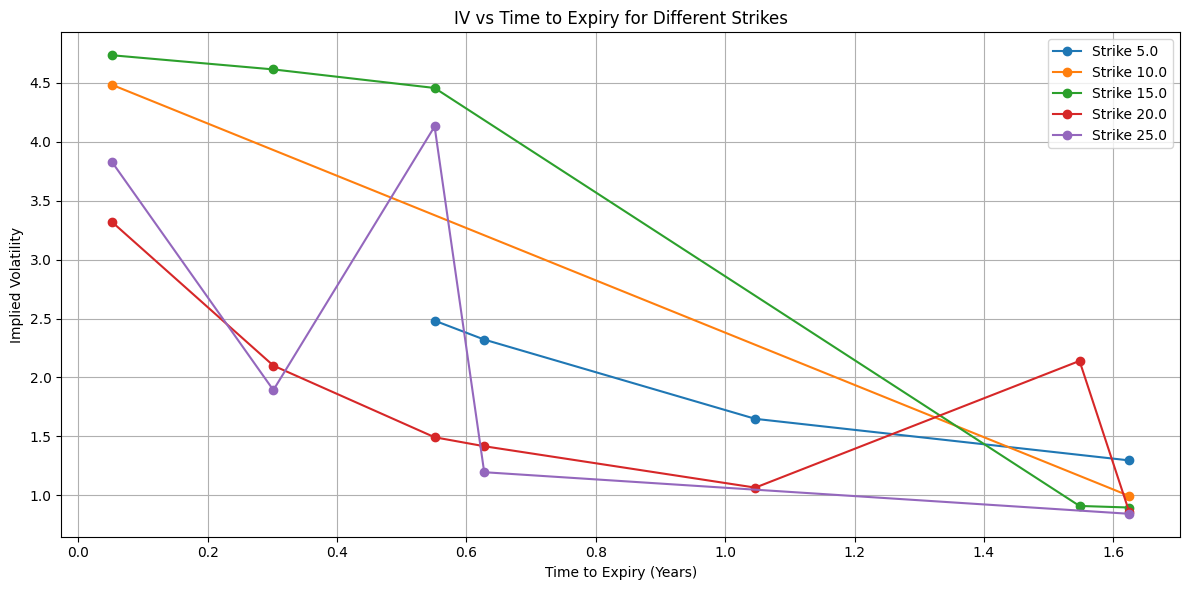

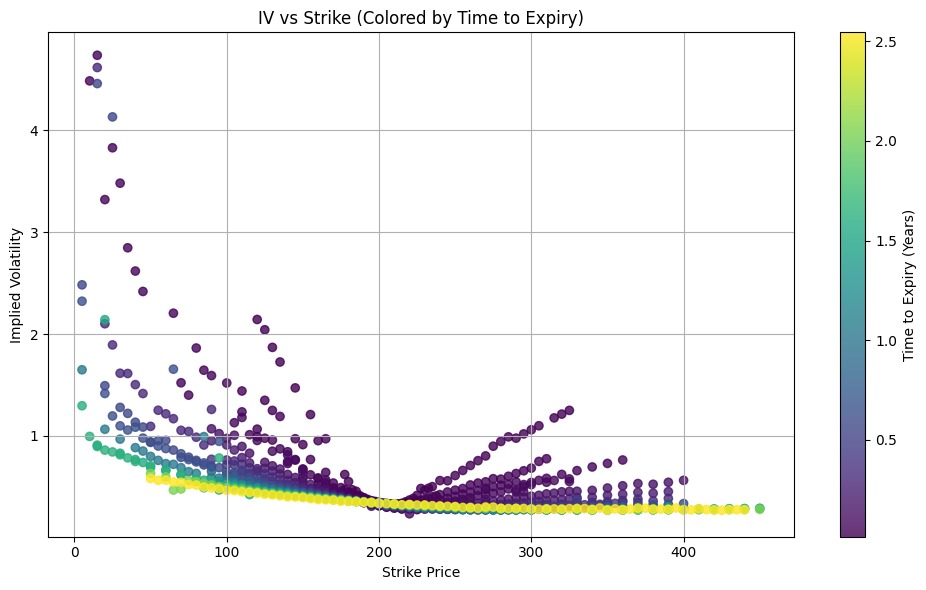

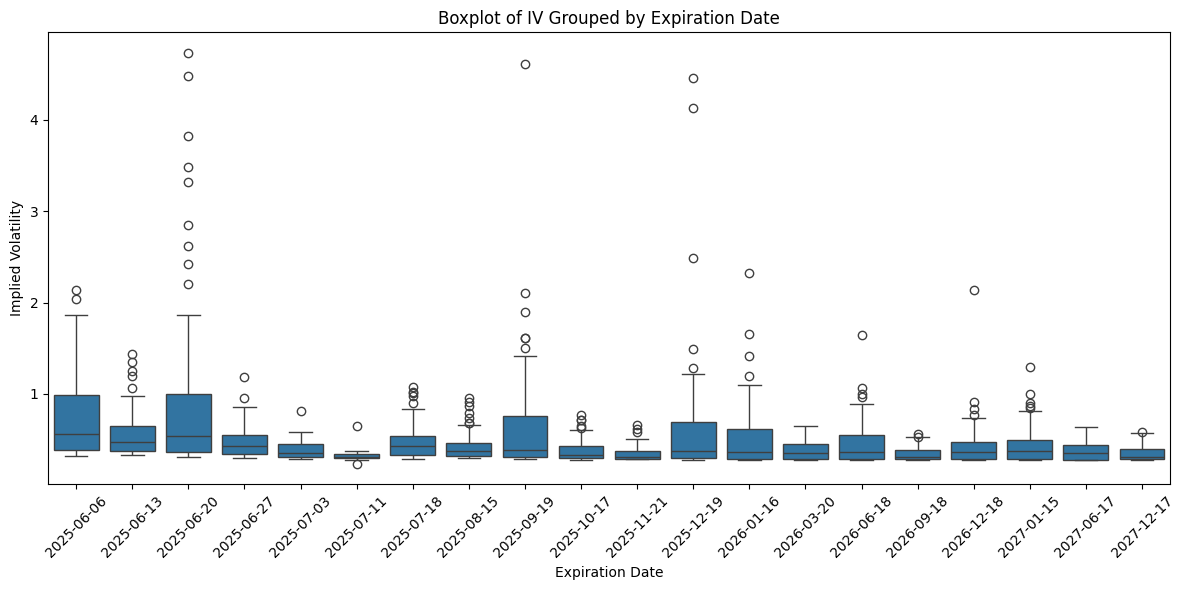

In [14]:
plot_iv_vs_expiry(filtered)
scatter_iv_by_strike_and_expiry(filtered)
boxplot_iv_by_expiry(filtered)

## ✅ Conclusion and Possible Extensions

In this project, we:

- Fetched real-time option chain data for a stock ticker
- Computed implied volatilities for calls and puts
- Constructed a volatility surface across strikes and expirations
- Visualized the surface to gain market insights

### 🚀 Possible Future Enhancements:
- Add real-time updates via a dashboard (e.g., Streamlit or Dash)
- Compute and overlay Greeks (Delta, Gamma, Vega, etc.)
- Compare historical IV vs. realized volatility
- Extend to American options using binomial trees

This notebook can serve as a robust base for both **research** and **trading analytics** in the options market.